In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
#from datetime import datetime


In [2]:
df = pd.read_csv('GOOG.csv')

#Separate dates for future plotting
train_dates = pd.to_datetime(df['Date'])
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-05-25,720.760010,727.510010,719.705017,725.270020,725.270020,1629200
1,2016-05-26,722.869995,728.330017,720.280029,724.119995,724.119995,1576300
2,2016-05-27,724.010010,733.935974,724.000000,732.659973,732.659973,1975000
3,2016-05-31,731.739990,739.729980,731.260010,735.719971,735.719971,2129500
4,2016-06-01,734.530029,737.210022,730.659973,734.150024,734.150024,1253600


In [3]:
#Variables for training
cols = list(df)[1:6]

df= df[cols].astype(float)
df.head()

,Open,High,Low,Close,Adj Close
0,720.760010,727.510010,719.705017,725.270020,725.270020
1,722.869995,728.330017,720.280029,724.119995,724.119995
2,724.010010,733.935974,724.000000,732.659973,732.659973
3,731.739990,739.729980,731.260010,735.719971,735.719971
4,734.530029,737.210022,730.659973,734.150024,734.150024


In [4]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
df = scaler.fit_transform(df)
#print(df)
split = int(len(df)*0.8)
split
train = df[0:split ,:]
test = df[split:,:]
train

array([[0.02860872, 0.03101551, 0.03244459, 0.03236208, 0.03236208],
       [0.02982182, 0.03147617, 0.03277525, 0.03170926, 0.03170926],
       [0.03047726, 0.03462544, 0.0349144 , 0.03655703, 0.03655703],
       ...,
       [0.41313605, 0.41465603, 0.41631263, 0.41919132, 0.41919132],
       [0.42372636, 0.41750419, 0.41987787, 0.41696616, 0.41696616],
       [0.41723533, 0.41597056, 0.4189463 , 0.42129169, 0.42129169]])

In [5]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [6]:
look_back = 30
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)
Y_train=np.reshape(Y_train, (Y_train.shape[0],1))
Y_test=np.reshape(Y_test, (Y_test.shape[0],1))

In [7]:
X_train.shape

(975, 30, 5)

In [8]:
# define Autoencoder model

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(Y_train.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 64)            17920     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 30,369
Trainable params: 30,369
Non-trainable params: 0
_________________________________________________________________


In [9]:
# fit model
history = model.fit(X_train, Y_train, epochs=50, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/50
55/55 [==============================] - 1s 27ms/step - loss: 0.0082 - val_loss: 0.0031
Epoch 2/50
55/55 [==============================] - 1s 18ms/step - loss: 0.0015 - val_loss: 0.0029
Epoch 3/50
55/55 [==============================] - 1s 19ms/step - loss: 0.0013 - val_loss: 0.0026
Epoch 4/50
55/55 [==============================] - 1s 20ms/step - loss: 0.0013 - val_loss: 0.0025
Epoch 5/50
55/55 [==============================] - 1s 19ms/step - loss: 0.0013 - val_loss: 0.0032
Epoch 6/50
55/55 [==============================] - 1s 19ms/step - loss: 0.0013 - val_loss: 0.0023
Epoch 7/50
55/55 [==============================] - 1s 18ms/step - loss: 0.0011 - val_loss: 0.0022
Epoch 8/50
55/55 [==============================] - 1s 18ms/step - loss: 0.0011 - val_loss: 0.0021
Epoch 9/50
55/55 [==============================] - 1s 18ms/step - loss: 9.7390e-04 - val_loss: 0.0026
Epoch 10/50
55/55 [==============================] - 1s 18ms/step - loss: 8.6778e-04 - val_loss: 0.0020
E

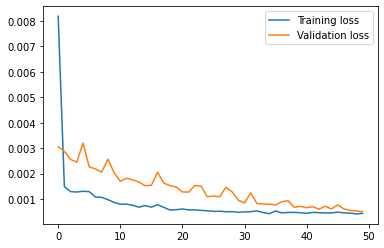

In [10]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [11]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)


In [ ]:
train_predict

In [12]:
# invert predictions
_copies = np.repeat(train_predict, train.shape[1], axis=-1)
train_predict = scaler.inverse_transform(_copies)[:,0]

_copies = np.repeat(Y_train, train.shape[1], axis=-1)
Y_train = scaler.inverse_transform(_copies)[:,0]

_copies = np.repeat(test_predict, test.shape[1], axis=-1)
test_predict = scaler.inverse_transform(_copies)[:,0]

_copies = np.repeat(Y_test, test.shape[1], axis=-1)
Y_test = scaler.inverse_transform(_copies)[:,0]

In [13]:
import math 
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(Y_test, test_predict))

40.74291878831272

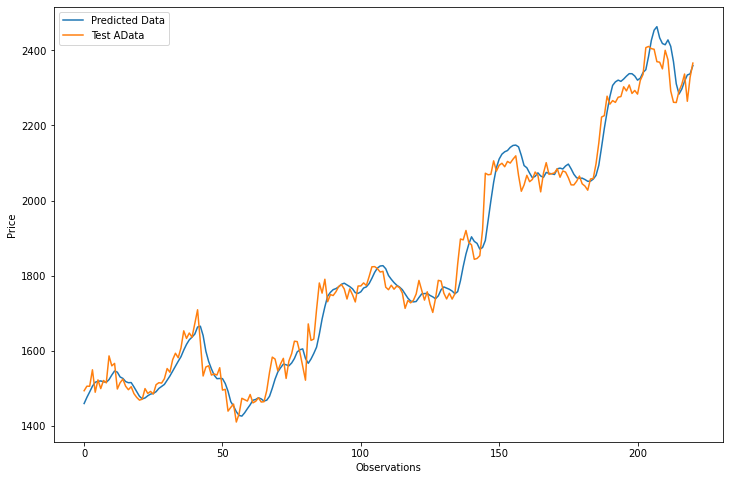

In [14]:
plt.figure(figsize=(12,8))
plt.plot(test_predict, label="Predicted Data")
plt.plot(Y_test, label="Test AData")
plt.xlabel("Observations")
plt.ylabel("Price")
plt.legend()
plt.show()

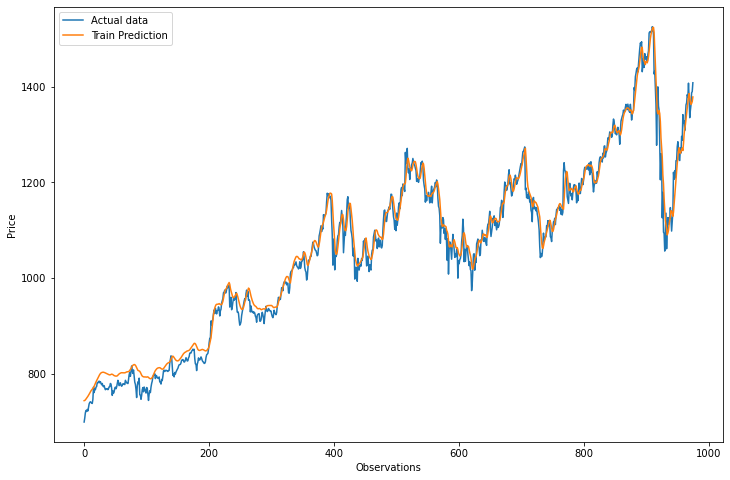

In [15]:
plt.figure(figsize=(12,8))
plt.plot(Y_train, label="Actual data")
plt.plot(train_predict, label="Train Prediction")
plt.xlabel("Observations")
plt.ylabel("Price")
plt.legend()
plt.show()

In [16]:
n_future=90 
forecast = model.predict(X_test[-n_future:]) 

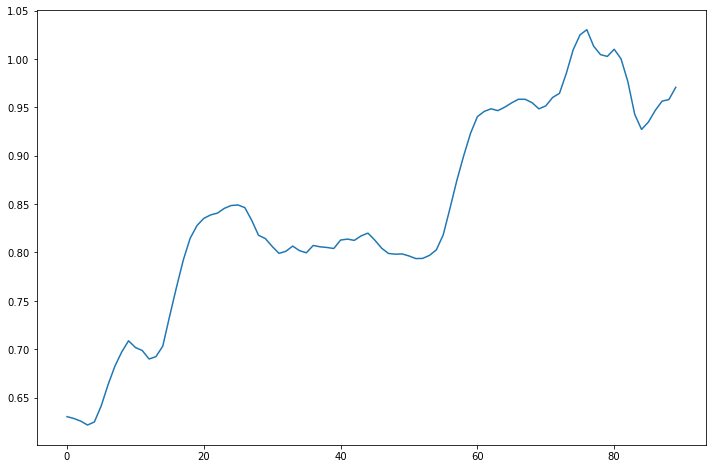

In [17]:
plt.figure(figsize=(12,8))
plt.plot(forecast, label="Train Prediction")
plt.show()